# 14 - AN(C)OVA

<center>
<img src="img/anova.png" alt="Testy różnic" width="600"/>
</center>

## Sumy kwadratów (SS)

### Całkowita suma kwadratów
$$
SS_{\text{Total}} = \sum_{i=1}^{k} \sum_{j=1}^{n_i} (Y_{ij} - \bar{Y})^2
$$

### Suma kwadratów między grupami (Between)
$$
SS_{\text{Between}} = \sum_{i=1}^{k} n_i (\bar{Y}_i - \bar{Y})^2
$$

### Suma kwadratów wewnątrz grup (Within)
$$
SS_{\text{Within}} = \sum_{i=1}^{k} \sum_{j=1}^{n_i} (Y_{ij} - \bar{Y}_i)^2
$$

### Relacja
$$
SS_{\text{Total}} = SS_{\text{Between}} + SS_{\text{Within}}
$$

### Statystyka F w Anovie
$$
F = \frac{MS_{\text{Between}}}{MS_{\text{Within}}}
$$

# ANOVA w Pythonie – wprowadzenie

Analiza wariancji (**ANOVA**, *Analysis of Variance*) służy do sprawdzania, czy **średnie kilku niezależnych grup** różnią się od siebie istotnie statystycznie. Porównujemy dwa źródła zmienności:

- **Między grupami (Between Groups)** – zmienność wynikająca z różnic między średnimi grup  
- **Wewnątrz grup (Within Groups / Residual)** – zmienność wynikająca z indywidualnych różnic w obrębie każdej grupy  

Jeśli grupy faktycznie się różnią, to **zmienność między grupami** będzie większa niż **zmienność w grupach**.


Model zapisujemy jako:

$$
Y_{ij} = \mu + \tau_i + \varepsilon_{ij}
$$

gdzie:  
- $Y_{ij}$ – obserwacja w grupie $i$, jednostce $j$  
- $\mu$ – ogólna średnia  
- $\tau_i$ – efekt grupy  
- $\varepsilon_{ij}$ – błąd losowy  


## Hipotezy w jednoczynnikowej ANOVA

- **H₀:** wszystkie średnie populacyjne są równe  
$$
  \mu_1 = \mu_2 = \dots = \mu_k
$$

- **H₁:** co najmniej dwie średnie różnią się między sobą

---

## ✔️ Założenia ANOVY

1. niezależność obserwacji  
2. normalność: rozkład w grupach przybliżony normalny  
3. jednorodność wariancji  

---

## 📊 Typowa tabela ANOVY

| Źródło zmienności | SS | df | MS | F | p-value |
|-------------------|-----|-----|-------|-----|---------|
| Between Groups    | $SS_b$ | $k-1$ | $MS_b$ | $F$ | p |
| Within Groups     | $SS_w$ | $N-k$ | $MS_w$ |     |   |
| Total             | $SS_t$ | $N-1$ |       |     |   |

---

## 🧭 Interpretacja testu

- **$H_0$:** wszystkie średnie są równe  
- **$H_1$:** przynajmniej jedna średnia różni się od innych  

Jeśli p-value < 0.05 → odrzucamy $H_0$.

## Tabela ANOVA 

| Źródło zmienności | SS (Sum of Squares) | df  | MS (Mean Square)              | F                           | p-value |
|-------------------|---------------------|-----|-------------------------------|-----------------------------|---------|
| Between Groups    | SS_between          | k-1 | SS_between/(k-1)              | MS_between/MS_within        | p       |
| Within Groups     | SS_within           | N-k | SS_within/(N-k)               | —                           | —       |
| Total             | SS_total            | N-1 | —                             | —                           | —       |

Gdzie:  
- `k` – liczba porównywanych grup  
- `N` – łączna liczba obserwacji

ANOVA opiera się na porównaniu dwóch wariancji: między grupami i wewnątrz grup. 
 
Jeśli proporcja ($F$) jest duża, oznacza to, że średnie różnią się bardziej, niż wynikałoby to z samej zmienności losowej.


---

## Przykład 1.

Dane pochodzą z amerykańskiego magazynu Motor Trend z 1974 roku i obejmują zużycie paliwa oraz 10 cech związanych z konstrukcją i osiągami 32 samochodów (modele z lat 1973–74).

W analizie chcemy rozważyć możliwe różnice w liczbie mil na galon (mpg) pomiędzy wybranymi grupami kontrolnymi, takimi jak liczba cylindrów.

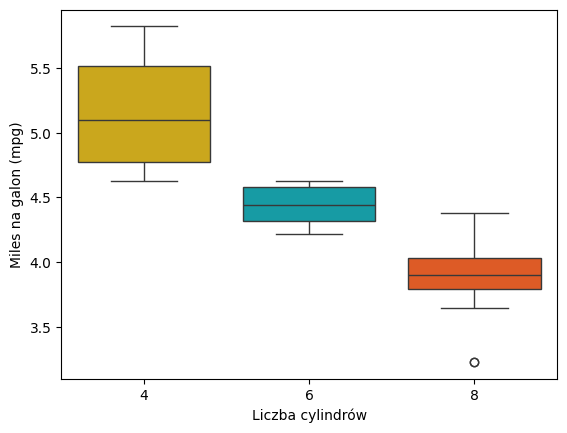

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Wczytanie danych mtcars
url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)

# Zamiana liczby cylindrów na tekst
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Wykres pudełkowy zgodny z nowszą wersją seaborn
sns.boxplot(
    x='cyl',
    y='mpg',
    hue='cyl',          # <- wymagane, jeśli używasz palette
    data=mtcars,
    palette=["#00AFBB", "#E7B800", "#FC4E07"],
    order=["4", "6", "8"],
    legend=False        # <- wyłącza niepotrzebną legendę
)

plt.xlabel("Liczba cylindrów")
plt.ylabel("Miles na galon (mpg)")

plt.show()


Zacznijmy najpierw od spojrzenia na przedziały ufności:

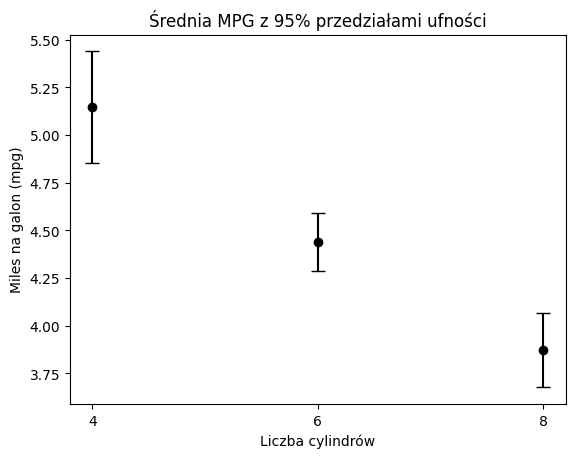

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# Obliczenie średnich i 95% CI dla mpg w grupach cylindrów
means = mtcars.groupby('cyl')['mpg'].mean()
conf_intervals = mtcars.groupby('cyl')['mpg'].apply(lambda x: DescrStatsW(x).tconfint_mean())

# Ekstrakcja dolnej i górnej granicy CI
lower_bounds = conf_intervals.apply(lambda x: x[0])
upper_bounds = conf_intervals.apply(lambda x: x[1])

# Wykres punktowy ze słupkami błędów (95% CI)
plt.errorbar(
    means.index,
    means,
    yerr=[means - lower_bounds, upper_bounds - means],
    fmt='o',
    capsize=5,
    color='black'
)

plt.xlabel("Liczba cylindrów")
plt.ylabel("Miles na galon (mpg)")
plt.title("Średnia MPG z 95% przedziałami ufności")

plt.show()


### 1-way Anova

Chcemy sprawdzić, czy istnieją jakiekolwiek istotne różnice pomiędzy średnią liczbą mil na galon w trzech typach samochodów (różniących się liczbą cylindrów).

Zacznijmy od sprawdzenia normalności rozkładu.

In [5]:
import pandas as pd
from scipy.stats import shapiro

# Grupujemy dane wg liczby cylindrów ('cyl') i wykonujemy test Shapiro–Wilka
# dla zmiennej 'mpg' w każdej grupie
shapiro_results = mtcars.groupby('cyl')['mpg'].apply(lambda x: shapiro(x))

# Tworzymy DataFrame z wynikami testu
shapiro_df = pd.DataFrame({
    'cyl': shapiro_results.index,
    'W': [result[0] for result in shapiro_results],
    'p-value': [result[1] for result in shapiro_results]
})

print(shapiro_df)


  cyl         W   p-value
0   4  0.915339  0.281708
1   6  0.898284  0.320719
2   8  0.915158  0.187208


Możemy również obejrzeć wykresy Q–Q sprawdzające normalność, razem z wynikami testu Shapiro–Wilka:

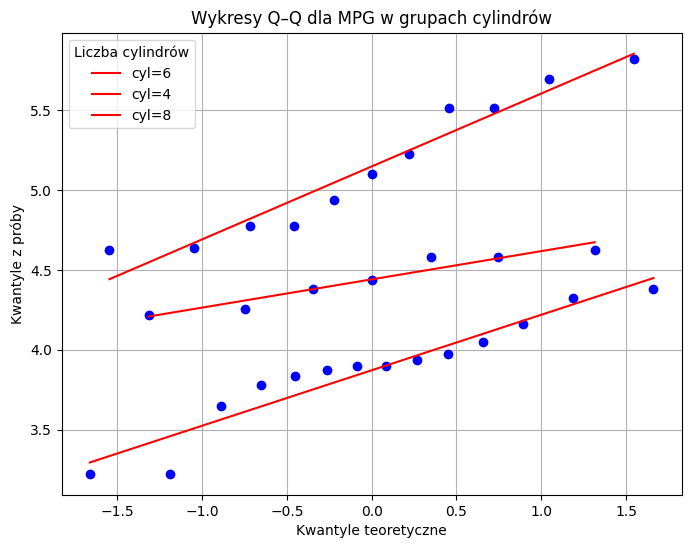

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Tworzymy wykresy Q–Q z linią odniesienia dla każdej grupy cylindrów
plt.figure(figsize=(8, 6))
for cyl in mtcars['cyl'].unique():
    subset = mtcars[mtcars['cyl'] == cyl]
    stats.probplot(subset['mpg'], dist="norm", plot=plt)
    plt.gca().get_lines()[-1].set_label(f'cyl={cyl}')  # etykieta dla legendy

plt.legend(title='Liczba cylindrów')
plt.xlabel('Kwantyle teoretyczne')
plt.ylabel('Kwantyle z próby')
plt.title('Wykresy Q–Q dla MPG w grupach cylindrów')
plt.grid(True)
plt.show()


- Nie widzimy żadnych odchyleń od linii normalności, a wartości p również sugerują brak podstaw do odrzucenia normalności.

- Kolejnym krokiem jest przetestowanie założenia o jednorodności wariancji. 

- Zdecydowanie polecam test Levene’a, który jest mniej wrażliwy na odchylenia od normalnego rozkładu.

In [8]:
from scipy.stats import levene
# Wykonanie testu Levene’a na równość wariancji
stat, p_value = levene(
    mtcars[mtcars['cyl'] == '4']['mpg'],
    mtcars[mtcars['cyl'] == '6']['mpg'],
    mtcars[mtcars['cyl'] == '8']['mpg']
)

print(f"Statystyka testu Levene’a: {stat}")
print(f"Wartość p: {p_value}")

Statystyka testu Levene’a: 2.868889131775262
Wartość p: 0.07296950644913475


Wartość p jest tylko nieco wyższa od naszego progu istotności α = 0.05, więc jeśli chcesz przeprowadzić bardziej odporną wersję ANOVA — czyli ANOVA Welcha — uruchom funkcję z biblioteki pingouin:

In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA using statsmodels
model = ols('mpg ~ cyl', data=mtcars).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_results)

             sum_sq    df          F        PR(>F)
cyl       10.013559   2.0  41.055426  3.477779e-09
Residual   3.536600  29.0        NaN           NaN


Jak widzimy, co najmniej jedna para średnich różni się istotnie statystycznie (H0 powinna zostać odrzucona). Oznacza to, że liczba mil na galon istotnie różni się pomiędzy samochodami o różnej liczbie cylindrów.

Skoro odrzuciliśmy H0, możemy przeprowadzić testy post-hoc: LSD (least-significant-differences) lub HSD (honestly-significant-differences).

Test Tukeya HSD służy do porównania wszystkich grup ze sobą — czyli wykonuje wszystkie możliwe porównania par 2 grup.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      6  -0.7064 0.0007 -1.1234 -0.2894   True
     4      8   -1.275    0.0 -1.6224 -0.9275   True
     6      8  -0.5686  0.004 -0.9678 -0.1693   True
----------------------------------------------------


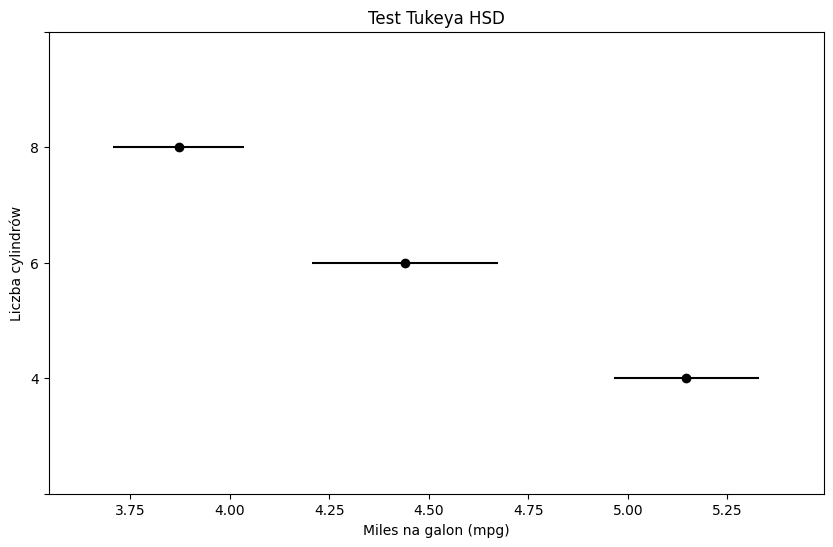

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Wykonanie testu Tukeya HSD
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Wyświetlenie wyników
print(tukey)

# Wykres wyników testu
tukey.plot_simultaneous()
plt.title('Test Tukeya HSD')
plt.xlabel('Miles na galon (mpg)')
plt.ylabel('Liczba cylindrów')
plt.show()


Jak widzimy powyżej, wszystkie pary średnich różnią się istotnie statystycznie (p < α).

Na koniec zwizualizujmy nasze wyniki razem z testem ANOVA oraz testami post-hoc:

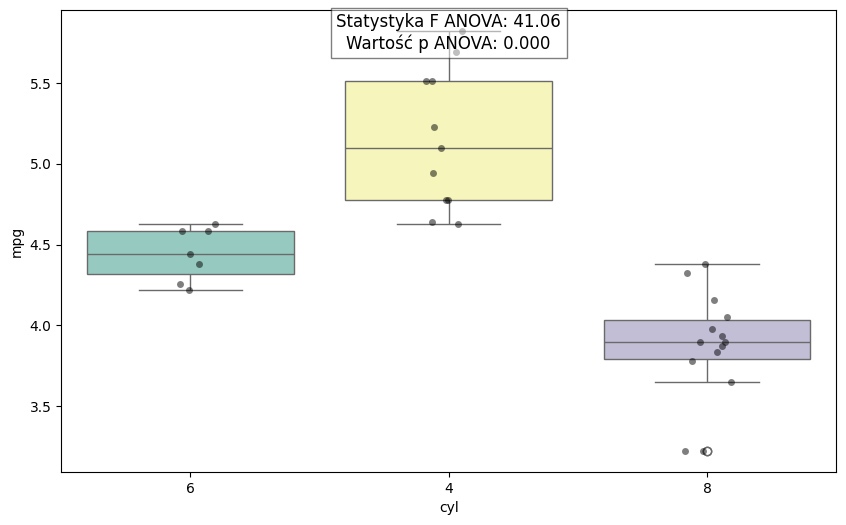

In [12]:
# Wykonanie testu Tukeya HSD
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))

# Boxplot: nowe wymagania seaborn
sns.boxplot(
    x='cyl',
    y='mpg',
    hue='cyl',
    data=mtcars,
    palette="Set3",
    legend=False
)

sns.stripplot(
    x='cyl',
    y='mpg',
    data=mtcars,
    color='black',
    jitter=True,
    alpha=0.5
)

# Dodanie wyników ANOVA
anova_text = (
    f"Statystyka F ANOVA: {anova_results['F'].iloc[0]:.2f}\n"
    f"Wartość p ANOVA: {anova_results['PR(>F)'].iloc[0]:.3f}"
)

plt.text(
    0.5, 0.95, anova_text,
    horizontalalignment='center',
    verticalalignment='center',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.show()


Zrób to sam (DIY):

A co z am (typ skrzyni biegów) i liczbą biegów (gear)?

In [13]:
# Twój kod tutaj!

---

## Zadanie 1. Twoja kolej!

Poniższy zbiór danych przedstawia wyniki dotyczące satysfakcji z pracy, uporządkowane według płci oraz poziomu wykształcenia.

W tym badaniu badacz chce ocenić, czy istnieje istotna dwuczynnikowa interakcja pomiędzy płcią a poziomem wykształcenia w wyjaśnianiu poziomu satysfakcji z pracy.

Efekt interakcji pojawia się wtedy, gdy wpływ jednej zmiennej niezależnej na zmienną wynikową zależy od poziomu drugiej zmiennej niezależnej.

Jeśli efektu interakcji nie ma, można raportować efekty główne.


In [14]:
import pandas as pd

# Wczytanie zbioru danych jobsatisfaction z mojego repozytorium GitHub:
url = "https://raw.githubusercontent.com/kflisikowski/ds/master/jobsatisfaction.csv"
jobsatisfaction = pd.read_csv(url)

In [15]:
# Twój kod tutaj!

---

## Wprowadzenie do Repeated Measures ANOVA

**Repeated Measures ANOVA** (ANOVA z powtarzanymi pomiarami) to metoda analizy statystycznej wykorzystywana wtedy, gdy **te same jednostki** (np. ci sami uczestnicy badania) są mierzone **w wielu warunkach** lub **w kilku punktach czasowych**.  
Oznacza to, że obserwacje są **zależne**, bo pochodzą od tych samych osób.

### 🔍 Kiedy stosujemy RM ANOVA?

RM ANOVA jest odpowiednia, gdy badacz chce sprawdzić, czy istnieją istotne różnice pomiędzy średnimi wartościami zmiennej zależnej w różnych pomiarach wykonanych na tej samej grupie.  
Przykłady:
- wynik testu mierzony **przed szkoleniem**, **po szkoleniu** i **miesiąc po szkoleniu**,  
- ciśnienie krwi mierzone **w spoczynku**, **po wysiłku**, **w trakcie regeneracji**,  
- ocena nastroju uczestników **rano**, **po południu** i **wieczorem**.

### ⭐ Dlaczego używamy tej metody?

Ponieważ ci sami uczestnicy pojawiają się w każdej kondycji, RM ANOVA:
- **eliminuje wpływ różnic indywidualnych** (każdy jest „swoją własną kontrolą”),  
- zwiększa **moc testu**,  
- wymaga mniejszej liczby uczestników niż klasyczne ANOVA międzygrupowe.

### 📌 Założenia RM ANOVA

1. **Normalność** rozkładu różnic pomiędzy pomiarami.  
2. **Sferyczność** (sphericity): wariancje różnic między wszystkimi parami warunków powinny być równe.  
   - Gdy założenie jest naruszone, stosuje się poprawki:  
     - **Greenhouse–Geisser**,  
     - **Huynh–Feldt**.

### 🧪 Co testuje RM ANOVA?

RM ANOVA sprawdza, czy średnie z różnych pomiarów **różnią się od siebie istotnie statystycznie**, czyli czy istnieje efekt czasu/warunku.

Jeśli wynik ANOVA jest istotny ⇒ wykonujemy **testy post-hoc**, aby sprawdzić, które pomiary różnią się między sobą.

---

## RM ANOVA w Pythonie

Kluczowe funkcje w Pythonie:

### statsmodels

**AnovaRM**: funkcja dostępna w pakiecie *statsmodels*, służy do przeprowadzania analizy wariancji z powtarzanymi pomiarami (Repeated Measures ANOVA).

```python
from statsmodels.stats.anova import AnovaRM


### pingouin

**rm_anova**: funkcja z biblioteki *pingouin*, również służy do przeprowadzania analizy RM ANOVA (ANOVA z powtarzanymi pomiarami).

```python
result = pg.rm_anova(dv='dependent_variable',
                     within='within_factor',
                     subject='subject',
                     data=data)

print(result)


---

## 1-way RM ANOVA

Zbiór danych **„selfesteem”** zawiera wyniki samooceny 10 osób,
zmierzone w trzech momentach czasowych podczas stosowania określonej diety,
aby sprawdzić, czy ich samoocena uległa poprawie.


In [16]:
import pandas as pd

# Adres URL do pliku CSV
url = "https://github.com/kflisikowski/ds/raw/master/selfesteem.csv"

# Wczytanie danych do DataFrame
selfesteem = pd.read_csv(url)

# Wyświetlenie pierwszych kilku wierszy danych
print(selfesteem.head())


   id        t1        t2        t3
0   1  4.005027  5.182286  7.107831
1   2  2.558124  6.912915  6.308434
2   3  3.244241  4.443434  9.778410
3   4  3.419538  4.711696  8.347124
4   5  2.871243  3.908429  6.457287


Jednoczynnikowa ANOVA z powtarzanymi pomiarami może zostać użyta do sprawdzenia, czy średnie poziomy samooceny różnią się istotnie pomiędzy trzema momentami pomiaru. Dlatego najpierw przekształćmy ramkę danych do formatu „long”.

In [17]:
# Przekształcenie danych do formatu long
selfesteem = selfesteem.melt(id_vars=['id'], value_vars=['t1', 't2', 't3'],
                             var_name='time', value_name='score')

# Konwersja kolumn 'id' oraz 'time' na typ kategoryczny
selfesteem['id'] = selfesteem['id'].astype('category')
selfesteem['time'] = selfesteem['time'].astype('category')

# Wyświetlenie pierwszych 3 wierszy przekształconych danych
print(selfesteem.head(3))


  id time     score
0  1   t1  4.005027
1  2   t1  2.558124
2  3   t1  3.244241


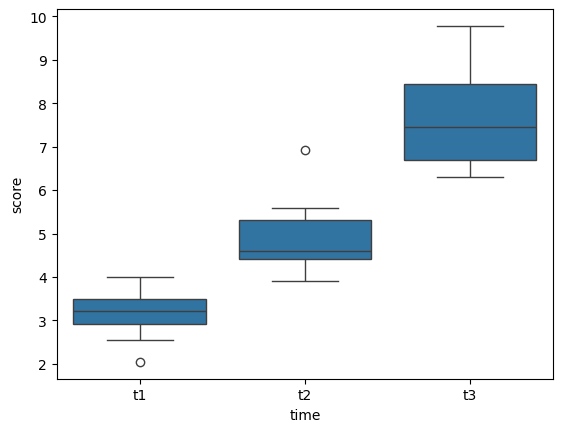

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tworzenie wykresu pudełkowego
bxp = sns.boxplot(x='time', y='score', data=selfesteem)

# Wyświetlenie wykresu
plt.show()


## Założenia

In [23]:
def identify_outliers(group):
    Q1 = group['score'].quantile(0.25)
    Q3 = group['score'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (group['score'] < (Q1 - 1.5 * IQR)) | (group['score'] > (Q3 + 1.5 * IQR))

    # kolumna 'time' została usunięta przez include_groups=False → dodajemy ją z nazwy grupy:
    result = group.loc[outliers].copy()
    result['time'] = group.name
    return result[['id', 'time', 'score']]

outliers = (
    selfesteem.groupby('time', observed=True)
              .apply(identify_outliers, include_groups=False)
              .reset_index(drop=True)
)

print(outliers)


  id time     score
0  6   t1  2.045868
1  2   t2  6.912915


In [27]:
import pingouin as pg

shapiro_results = selfesteem.groupby('time', observed=True).apply(
    lambda x: pg.normality(x['score'], method='shapiro'),
    include_groups=False
)

print(shapiro_results)


                   W      pval  normal
time                                  
t1   score  0.966690  0.858576    True
t2   score  0.875885  0.116996    True
t3   score  0.922715  0.380156    True


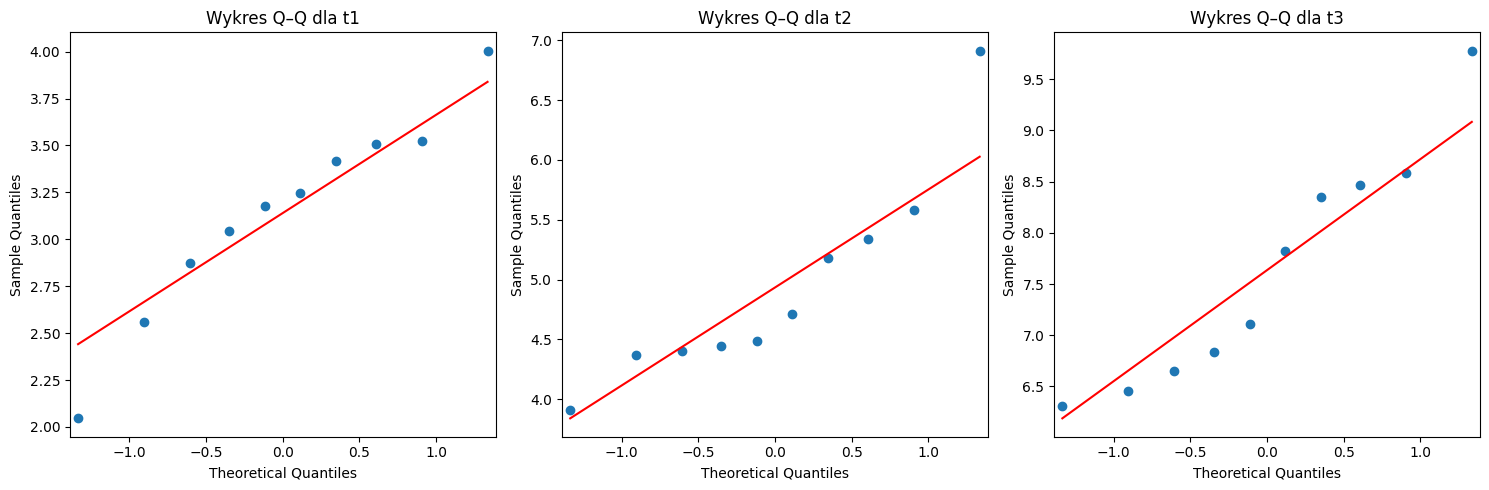

In [28]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Tworzenie wykresów Q–Q dla każdej grupy czasowej
time_groups = selfesteem['time'].unique()
fig, axes = plt.subplots(1, len(time_groups), figsize=(15, 5))

for i, time in enumerate(time_groups):
    sm.qqplot(selfesteem[selfesteem['time'] == time]['score'], line='s', ax=axes[i])
    axes[i].set_title(f'Wykres Q–Q dla {time}')

plt.tight_layout()
plt.show()


### 🌀 Sphericity (sferyczność)

**Sferyczność** to jedno z kluczowych założeń jednoczynnikowej ANOVA z powtarzanymi pomiarami (RM ANOVA).

### 🔍 Co oznacza sferyczność?

Sferyczność oznacza, że:

> **wariancje różnic pomiędzy wszystkimi parami poziomów czynnika wewnątrzobiektowego są takie same.**

Czyli:
- różnice między t1 a t2 mają podobną wariancję,
- różnice między t1 a t3 mają podobną wariancję,
- różnice między t2 a t3 mają podobną wariancję.

Jeśli te wariancje są zbliżone — założenie sferyczności jest spełnione.

### 🧪 Jak testujemy sferyczność?

Najczęściej używa się do tego:

- **testu Mauchly’ego** (Mauchly's Test of Sphericity)

Jeżeli wynik testu jest istotny (p < 0.05), oznacza to, że:

❌ sferyczność jest naruszona.

### 🔧 Co jeśli sferyczności nie ma?

RM ANOVA jest wtedy zbyt liberalna (zaniżone p-value).  
W takim przypadku stosujemy poprawki:

- **Greenhouse–Geisser**
- **Huynh–Feldt**

Dają one bardziej konserwatywne wyniki i „korygują” stopnie swobody, aby ANOVA była wiarygodna mimo naruszenia sferyczności.

### 📌 Podsumowanie

- Sferyczność dotyczy *różnic między poziomami*, a nie samych poziomów.  
- Naruszenie tego założenia jest bardzo częste przy co najmniej 3 pomiarach.  
- Jeśli sferyczność jest naruszona → używamy korekt GG lub HF.  
- Biblioteka `pingouin` automatycznie podaje wyniki z korektami.



In [29]:
import pingouin as pg
spher = pg.sphericity(selfesteem, dv='score', subject='id', within='time')
print(spher)

SpherResults(spher=True, W=np.float64(0.5508534046691561), chi2=np.float64(4.770292467677472), dof=2, pval=np.float64(0.09207551403887483))


Jeśli wartość p jest mniejsza niż 0.05, oznacza to, że założenie sferyczności zostało naruszone i należy zastosować odpowiednią korektę stopni swobody (np. korektę Greenhouse’a–Geissera).

Jeśli wartość p jest większa niż 0.05, oznacza to, że założenie sferyczności jest spełnione.

In [30]:
# Wykonanie jednoczynnikowej ANOVA z powtarzanymi pomiarami
results = pg.rm_anova(data=selfesteem, dv='score', within='time', subject='id')

# Wyświetlenie wyników
print(results)


  Source  ddof1  ddof2          F         p-unc       ng2       eps
0   time      2     18  55.469027  2.013829e-08  0.828595  0.690061


## Jak interpretować wyniki RM ANOVA?

**Source:** Źródło wariancji. W tym przypadku jest to `time`, co oznacza analizę wpływu czasu na zmienną `score`.

**ddof1:** Stopnie swobody dla czynnika `time` (df_between).  
Ponieważ mamy trzy pomiary (t1, t2, t3), to:  
**df_between = liczba poziomów – 1 = 3 – 1 = 2**.

**ddof2:** Stopnie swobody dla błędu (df_within).  
Wynosi **18**, co wynika z liczby uczestników przemnożonej przez (liczba poziomów – 1).

**F:** Statystyka F. Informuje, jak duże są różnice między średnimi w stosunku do zmienności wewnątrz grup. Wyższa wartość F wskazuje na większe różnice między pomiarami.

**p-unc:** Wartość p (niekorygowana).  
Pokazuje, czy różnice między pomiarami są statystycznie istotne.  
**p < 0.05** oznacza istotne różnice.

**np2:** Eta-kwadrat (η²) — miara wielkości efektu.  
Informuje, jaka część wariancji wyników może być wyjaśniona przez czynnik `time`.

Interpretacja eta-square:
- **0.01** — mały efekt  
- **0.06** — średni efekt  
- **0.14** — duży efekt


### Testy post-hoc

In [31]:
# Wykonanie porównań post-hoc z korektą Bonferroniego
pwc = pg.pairwise_tests(dv='score', within='time', subject='id',
                        data=selfesteem, padjust='bonferroni')

# Wyświetlenie wyników
print(pwc)


  Contrast   A   B  Paired  Parametric          T  dof alternative  \
0     time  t1  t2    True        True  -4.967618  9.0   two-sided   
1     time  t1  t3    True        True -13.228148  9.0   two-sided   
2     time  t2  t3    True        True  -4.867816  9.0   two-sided   

          p-unc    p-corr    p-adjust      BF10    hedges  
0  7.724196e-04  0.002317  bonferroni    50.694 -2.371801  
1  3.343804e-07  0.000001  bonferroni  4.02e+04 -4.799517  
2  8.861912e-04  0.002659  bonferroni    45.195 -2.556194  


/var/folders/52/jywb2x0n3tbfhc83q6yhpn5c0000gn/T/ipykernel_10190/754861677.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time', y='score', data=selfesteem, palette="Set3")


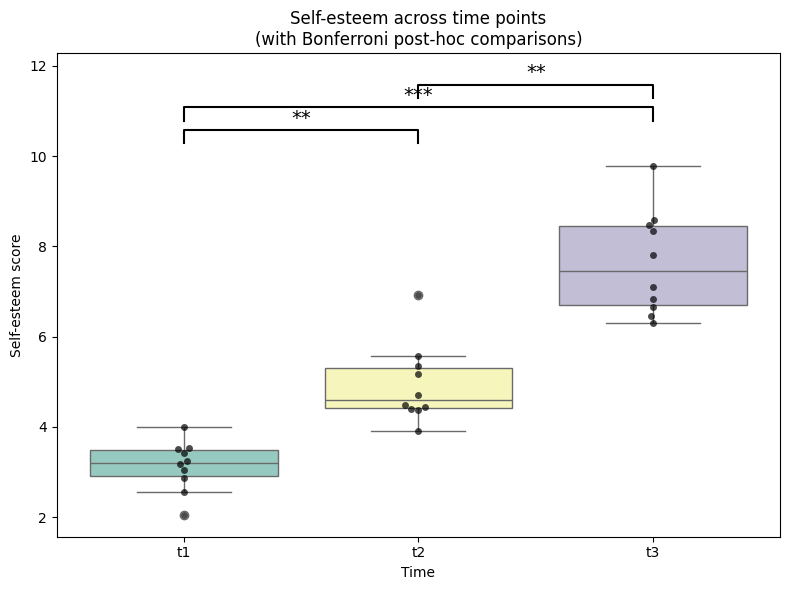

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Podstawowy wykres: boxplot + swarm (rozrzut punktów)
plt.figure(figsize=(8, 6))
sns.boxplot(x='time', y='score', data=selfesteem, palette="Set3")
sns.swarmplot(x='time', y='score', data=selfesteem, color='black', alpha=0.7)

# Wyciągnięcie istotnych par z post-hoc
sig_pairs = pwc[pwc['p-corr'] < 0.05][['A','B','p-corr']]

# Funkcja rysująca adnotacje nad wykresem
def add_sig_annotation(x1, x2, y, p):
    plt.plot([x1, x1, x2, x2], [y, y+0.3, y+0.3, y], lw=1.5, c='black')
    
    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = "ns"
        
    plt.text((x1 + x2)/2, y + 0.35, label, ha='center', va='bottom', fontsize=14)

# Ustalanie wysokości adnotacji
ymax = selfesteem['score'].max()
step = 0.5
current_y = ymax + 0.5

# Dodawanie anotacji dla istotnych par
for _, row in sig_pairs.iterrows():
    x1 = int(row['A'][-1]) - 1   # t1 → 0, t2 → 1, t3 → 2
    x2 = int(row['B'][-1]) - 1
    add_sig_annotation(x1, x2, current_y, row['p-corr'])
    current_y += step

plt.title("Self-esteem across time points\n(with Bonferroni post-hoc comparisons)")
plt.xlabel("Time")
plt.ylabel("Self-esteem score")
plt.ylim(top=current_y + 0.5)   # żeby się wszystko zmieściło

plt.tight_layout()
plt.show()


---

# Anova z interakcjami



ANOVA z interakcjami pozwala sprawdzić:
1. **Efekt główny** każdego czynnika (np. dieta, ćwiczenia),
2. **Efekt interakcji** — czyli czy wpływ jednego czynnika zależy od poziomu drugiego.

Interakcja występuje wtedy, gdy różnice między poziomami czynnika A zmieniają się przy różnych poziomach czynnika B. 
 
Przykład: jeśli dieta działa inaczej przy treningu cardio niż przy treningu siłowym.

---


## Przykład — Cereal Dataset (Kaggle)

W tej analizie sprawdzamy, czy **kaloryczność płatków śniadaniowych** (`calories`)
zależy od:

- **shelf** — poziomu półki w sklepie (1, 2, 3)
- **fiber_group** — grup błonnika (low / medium / high)
- oraz **interakcji** między tymi czynnikami.

Korzystamy z publicznego *Cereal Dataset* pobranego z Kaggle przez `kagglehub`.

---

In [18]:
# Cereal dataset (Kaggle: "Cereal Dataset")
# https://www.kaggle.com/datasets/crawford/80-cereals
import kagglehub
path = kagglehub.dataset_download("crawford/80-cereals")

In [24]:
df = pd.read_csv(path + "/cereal.csv")
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


Używamy tylko:
- calories
- fiber
- shelf

In [26]:
df = df[['calories', 'fiber', 'shelf']].dropna()

df['shelf'] = df['shelf'].astype('category')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   calories  77 non-null     int64   
 1   fiber     77 non-null     float64 
 2   shelf     77 non-null     category
dtypes: category(1), float64(1), int64(1)
memory usage: 1.5 KB


Tworzenie kategorii błonnika (fiber_group)

Podział:
- low: 0–1
- medium: 1–3
- high: 3+

In [27]:
df['fiber_group'] = pd.cut(
    df['fiber'],
    bins=[-0.01, 1, 3, df['fiber'].max()],
    labels=['low', 'medium', 'high']
)

df['fiber_group'] = df['fiber_group'].astype('category')

df.head()

,calories,fiber,shelf,fiber_group
0,70,10.0,3,high
1,120,2.0,3,medium
2,70,9.0,3,high
3,50,14.0,3,high
4,110,1.0,3,low


Sprawdźmy tabelę krzyżową (kontyngencji!) aby upewnić się, że ANOVA z interakcją jest możliwa.

In [29]:
df.groupby(['shelf', 'fiber_group'], observed=True).size()

shelf  fiber_group
1      low             9
       medium          9
       high            2
2      low            17
       medium          3
       high            1
3      low             9
       medium         18
       high            9
dtype: int64

Two-way ANOVA z interakcją:

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("calories ~ shelf * fiber_group", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
shelf,777.836962,2.0,1.176047,0.314691
fiber_group,1468.630613,2.0,2.220490,0.116369
shelf:fiber_group,4336.248005,4.0,3.278086,0.016181
Residual,22487.581699,68.0,NaN,NaN


Interpretacja wyników:

✔ Efekt główny półki (shelf)
Jeśli p < 0.05 → średnia kaloryczność różni się między półkami.
Często płatki na półce 1 (niżej) mają inne wartości niż te wyżej.

✔ Efekt główny błonnika (fiber_group)
Jeśli p < 0.05 → ilość błonnika wpływa na kaloryczność płatków.
Płatki „high fiber” zwykle mają mniej kalorii.

✔ Interakcja (shelf:fiber_group)
Jeśli p < 0.05 → wpływ błonnika na kalorie zależy od tego, na której półce leżą płatki.
Np. na półce 3 różnice kalorii mogą być większe niż na półce 1.

Wykres interakcji — żeby zobaczyć, co tu się dzieje:

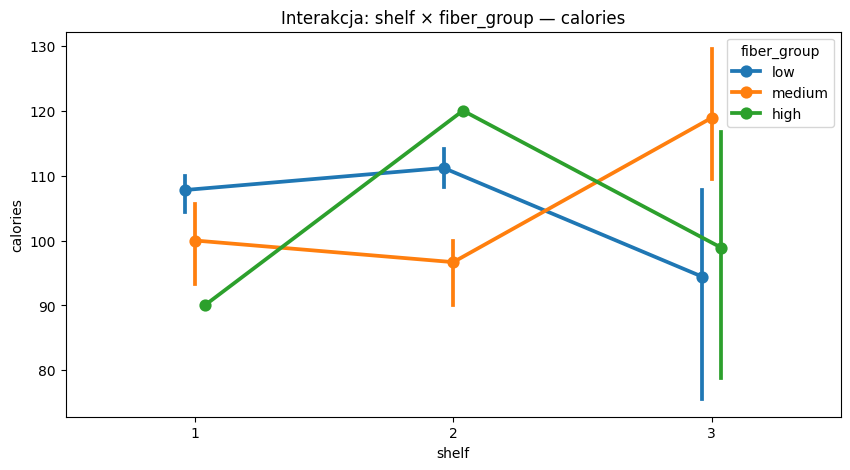

In [31]:
plt.figure(figsize=(10,5))
sns.pointplot(data=df, x='shelf', y='calories', hue='fiber_group', dodge=True)
plt.title("Interakcja: shelf × fiber_group — calories")
plt.show()

QQ-plot reszt (dla zasadności użycia Anovy parametrycznej):

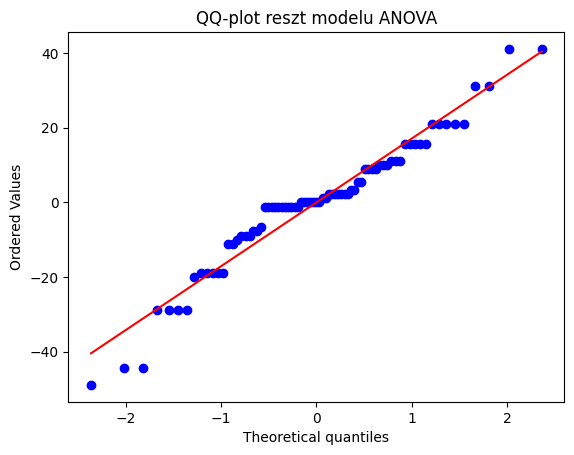

In [33]:
import scipy.stats as stats
import numpy as np
res = model.resid

stats.probplot(res, dist="norm", plot=plt)
plt.title("QQ-plot reszt modelu ANOVA")
plt.show()

## Co zrobić, gdy założenia ANOVA nie są spełnione?

Klasyczna ANOVA zakłada normalność reszt i równość wariancji między grupami.  

W praktyce dane często naruszają te założenia — zwłaszcza gdy są skośne, mają outliery lub bardzo różne wariancje. 
 
Co wtedy?

## Porównanie metod ANOVA przy naruszeniach założeń

Poniższa tabela podsumowuje, kiedy stosować klasyczną ANOVA, Welch ANOVA oraz robust ANOVA.

| Metoda | Kiedy stosować | Założenia | Zalety | Ograniczenia |
|-------|----------------|-----------|--------|--------------|
| **Klasyczna ANOVA** | Dane w miarę normalne, wariancje podobne | Normalność reszt, równość wariancji, brak outlierów | Standardowa, łatwa interpretacja, szeroko znana | Wrażliwa na outliery i nierówne wariancje; zniekształca wyniki przy naruszeniach |
| **Welch ANOVA** | Gdy wariancje są nierówne lub brak normalności | Brak wymogu równości wariancji, odporna na lekką nienormalność | Bardzo stabilna; najczęściej polecana przy heterogenicznych grupach | Dostępna głównie dla 1 czynnika (one-way ANOVA) |
| **Robust ANOVA (trimmed means)** | Gdy dane mają outliery, skośność, silne naruszenia normalności | Nie wymaga normalności; odporna na wartości odstające | Działa dla układów wieloczynnikowych; bardzo odporna | Wyniki mniej intuicyjne; rzadziej wykładana na poziomie podstawowym |
| **Bootstrap ANOVA** | Gdy chcemy pozostać przy klasycznej ANOVA, ale obejść założenia | Minimalne założenia; model estymowany przez resampling | Elastyczna, działa przy dowolnych rozkładach | Bardziej czasochłonna; wymaga interpretacji bootstrapowanych wartości |

### Szybkie rekomendacje
- **Masz outliery lub silną skośność?** → *Robust ANOVA*  
- **Nierówne wariancje?** → *Welch ANOVA*  
- **Chcesz pozostać przy ANOVA, ale dane „nie spełniają teorii”?** → *Bootstrap ANOVA*  
- **Dane czyste, warunki spełnione?** → *Klasyczna ANOVA*  

W praktyce w nowoczesnych analizach coraz częściej preferuje się **Welch** lub **robust ANOVA**, jako bardziej odporne i stabilne wnioskowanie.


## ANCOVA

**ANCOVA (Analysis of Covariance)** łączy cechy ANOVA i regresji liniowej.  
Pozwala jednocześnie:

- porównywać **średnie między grupami** (jak w ANOVA),
- kontrolować wpływ **dodatkowej zmiennej ilościowej** – tzw. **kowariaty** (covariate),
- oraz redukować wariancję błędu, zwiększając moc statystyczną analizy.

ANCOVA odpowiada na pytanie:

**Czy grupy różnią się średnią wartości zmiennej zależnej, po uwzględnieniu (skorygowaniu) wpływu zmiennej ilościowej?**

---

### Elementy modelu ANCOVA

- **Zmienna zależna (DV)** – ilościowa (np. wynik, czas, masa ciała)
- **Czynnik (factor)** – zmienna kategoryczna (np. grupa eksperymentalna)
- **Kowariata (covariate)** – zmienna ilościowa wpływająca na DV (np. wiek, wzrost, wyjściowy poziom umiejętności)

Model ANCOVA można zapisać jako:
  
$$\text{DV} = \text{factor} + \text{covariate} + \text{error}$$

---

### Założenia ANCOVA

1. **Liniowy związek** między kowariatą a DV.  
2. **Jednakowość nachyleń** (homogeneity of regression slopes) – wpływ kowariaty jest taki sam w każdej grupie.  
3. Normalność reszt i homogeniczność wariancji (jak w ANOVA).  
4. Kowariata jest **niezależna od czynnika** (tzn. grupy nie powinny różnić się systematycznie np. wiekiem).

---

### Kiedy stosować ANCOVA?

- Gdy chcemy **skorygować** średnie grup o wpływ dodatkowej zmiennej.  
- Gdy grupy początkowo **różniły się** pewną cechą początkową (pre-test).  
- Gdy chcemy zwiększyć moc testu przez redukcję wariancji błędu.  
- W badaniach eksperymentalnych, klinicznych, psychologicznych i edukacyjnych.

---

### Interpretacja

ANCOVA zwraca:
- efekt czynnika **po uwzględnieniu kowariaty**,  
- efekt kowariaty (czy istotnie wpływa na DV),  
- skorygowane średnie grup,  
- test nachyleń regresji (dla sprawdzenia założenia interakcji).

---

### Najważniejsza myśl

> **ANCOVA to ANOVA, która dodatkowo kontroluje wpływ zmiennej ilościowej — dzięki temu porównanie grup jest bardziej precyzyjne i sprawiedliwe.**

---

### Przykład - Utrata wagi

Pytanie badawcze: Chcemy sprawdzić, czy utrata wagi różni się w zależności od stosowanej diety oraz płci.
Musimy utworzyć zmienną „utrata wagi”, ponieważ to właśnie tę zmienną ciągłą chcemy porównywać między różnymi dietami i płciami.

In [51]:
url = "https://github.com/kflisikowski/ms/blob/main/diet.csv?raw=true"
diet = pd.read_csv(url)
diet['weightlost'] = diet['weight6weeks'] - diet['pre.weight']
diet.replace('', np.nan, inplace=True)
diet['gender'] = diet['gender'].replace({'0': 'Female', '1': 'Male'})
diet['Diet'] = diet['Diet'].replace({1: 'Diet 1', 2: 'Diet 2', 3: 'Diet 3'})
print(diet.head())

   Person  gender  Age  Height  pre.weight    Diet  weight6weeks  weightlost
0      25           41     171          60  Diet 2          60.0         0.0
1      26           32     174         103  Diet 2         103.0         0.0
2       1  Female   22     159          58  Diet 1          54.2        -3.8
3       2  Female   46     192          60  Diet 1          54.0        -6.0
4       3  Female   55     170          64  Diet 1          63.3        -0.7


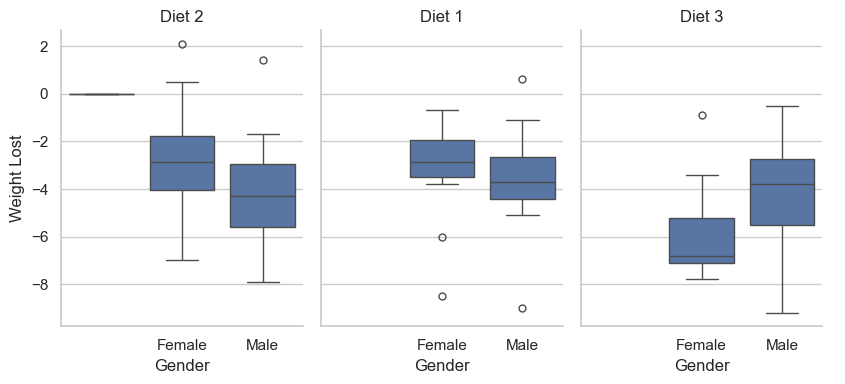

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot
sns.set(style="whitegrid")
g = sns.catplot(x="gender", y="weightlost", col="Diet", data=diet, kind="box", height=4, aspect=0.7)

# Set the titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Weight Lost")

# Show the plot
plt.show()

#### Założenie o normalności rozkładów w grupach

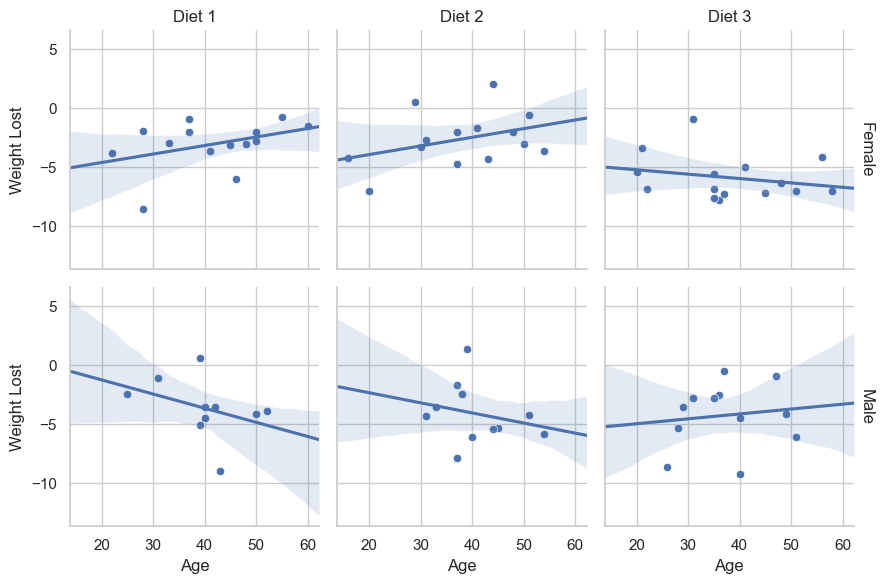

In [54]:
diet = diet[diet['gender'].isin(['Female', 'Male'])]

g = sns.FacetGrid(diet, col="Diet", row="gender", margin_titles=True)

g.map(sns.scatterplot, "Age", "weightlost")
g.map(sns.regplot, "Age", "weightlost", scatter=False, truncate=False)

g.set_axis_labels("Age", "Weight Lost")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.tight_layout()

plt.show()

In [ ]:
from scipy.stats import shapiro

def shapiro_test_vector(x):
    stat, p_value = shapiro(x.dropna())
    return pd.Series({'W-statistic': stat, 'p-value': p_value})

shapiro_results = (
    diet
    .groupby(['gender', 'Diet'])['weightlost'] 
    .apply(shapiro_test_vector)
    .reset_index()
)

print(shapiro_results)


    gender    Diet      level_2  weightlost
0   Female  Diet 1  W-statistic    0.851801
1   Female  Diet 1      p-value    0.023499
2   Female  Diet 2  W-statistic    0.978617
3   Female  Diet 2      p-value    0.966003
4   Female  Diet 3  W-statistic    0.849200
5   Female  Diet 3      p-value    0.016919
6     Male  Diet 1  W-statistic    0.936675
7     Male  Diet 1      p-value    0.516641
8     Male  Diet 2  W-statistic    0.950221
9     Male  Diet 2      p-value    0.646775
10    Male  Diet 3  W-statistic    0.941426
11    Male  Diet 3      p-value    0.516766


#### Założenie o jednorodnej wariancji w grupach

In [61]:
from scipy.stats import levene
diet['gender_Diet'] = diet['gender'] + '_' + diet['Diet']

groups = [group['weightlost'].dropna().values for name, group in diet.groupby('gender_Diet')]
stat, p_value = levene(*groups)

print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 0.38669356585167536
p-value: 0.8563346613193741


---

2-way Anova:

In [62]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('weightlost ~ gender * Diet', data=diet).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq    df         F    PR(>F)
gender         0.168696   1.0  0.031379  0.859910
Diet          60.417220   2.0  5.619026  0.005456
gender:Diet   33.904068   2.0  3.153204  0.048842
Residual     376.329043  70.0       NaN       NaN


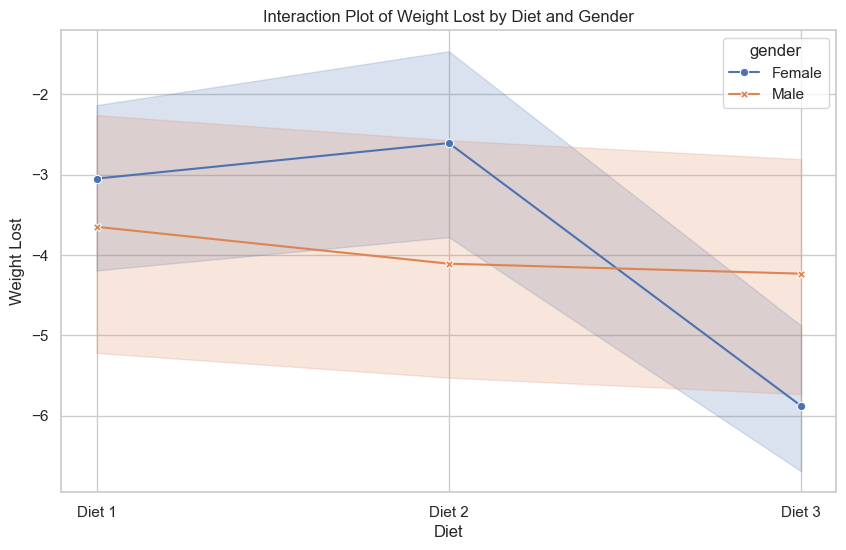

In [63]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=diet, x='Diet', y='weightlost', hue='gender', style='gender', markers=True, dashes=False)

plt.xlabel('Diet')
plt.ylabel('Weight Lost')
plt.title('Interaction Plot of Weight Lost by Diet and Gender')
plt.show()

Wnioski?

---

### 1-way ANCOVA

In [64]:
model = ols('weightlost ~ Diet + Height', data=diet).fit()
ancova_table = sm.stats.anova_lm(model, type=2)
print(ancova_table)

            df      sum_sq    mean_sq         F    PR(>F)
Diet       2.0   60.527008  30.263504  5.315323  0.007029
Height     1.0    0.460119   0.460119  0.080813  0.777015
Residual  72.0  409.941688   5.693635       NaN       NaN


Wnioski?

---

### 2-way ANCOVA z interakcjami

In [65]:
model2 = ols('weightlost ~ gender*Diet + Height', data=diet).fit()
ancova_table = sm.stats.anova_lm(model2, type=2)
print(ancova_table)

               df      sum_sq    mean_sq         F    PR(>F)
gender        1.0    0.278485   0.278485  0.051231  0.821605
Diet          2.0   60.417220  30.208610  5.557228  0.005785
gender:Diet   2.0   33.904068  16.952034  3.118526  0.050512
Height        1.0    1.251031   1.251031  0.230142  0.632936
Residual     69.0  375.078013   5.435913       NaN       NaN


Wnioski?

---